In [29]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import glob
from datetime import datetime
import string
from collections import Counter
from tqdm import tqdm, notebook
from nltk.corpus import stopwords
tqdm.pandas()
import en_core_web_sm
from nltk.stem.wordnet import WordNetLemmatizer

# don't display warnings info
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Gensim
# !pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
# set the environment for mallet
os.environ.update({'MALLET_HOME':r'C:\Users\saksh\Mallet\mallet-2.0.8'})
mallet_path = r'C:\Users\saksh\Mallet\mallet-2.0.8\bin\mallet'# update this path

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Nltk for text processing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')


C:\Users\saksh\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# spacy for lemmatization
import spacy
# model storage
import pickle
import joblib

# Data Cleaning
## Import Datasets
### Read the scraped FOX News

In [3]:
fox_coronav = pd.read_excel(r'C:\Users\saksh\COVID-19_UCD_Challenge\News_Fox_CNN\foxnews_article_form.xlsx')
fox_coronav.head()

,true_time,headline,link,summary,content
0,2020-04-09 00:00:00,Wife of Edmonton Oilers' Colby Cave gives upda...,https://www.foxnews.com/sports/wife-of-edmonto...,The wife of Edmonton Oilers forward Colby Cave...,The wife of Edmonton Oilers forward Colby Cave...
1,2020-04-09 00:00:00,"Body of RFK granddaughter’s son, 8, recovered ...",https://www.foxnews.com/us/body-of-rfk-grandda...,The body of 8-year-old Gideon McKean was recov...,The body of 8-year-old Gideon McKean was recov...
2,2020-04-09 00:00:00,Hundreds of inmates at Washington state correc...,https://www.foxnews.com/us/hundreds-of-inmates...,Authorities in Washington state responded late...,Get all the latest news on coronavirus and mor...
3,2020-04-09 00:00:00,"Nikki Haley, in op-ed, says coronavirus respon...",https://www.foxnews.com/politics/nikki-haley-i...,Responsibility for combating the coronavirus o...,Get all the latest news on coronavirus and mor...
4,2020-04-09 00:00:00,Barr disappointed by partisan attacks leveled ...,https://www.foxnews.com/media/ag-william-barr-...,"Attorney General William Barr told ""The Ingrah...",Get all the latest news on coronavirus and mor...


In [4]:
# drop the nulls, transform the datatime type
fox_coronav = fox_coronav.dropna()
date = datetime.strptime('2020-1-22', '%Y-%m-%d')
df1 = fox_coronav.loc[fox_coronav['true_time']> date,:]

In [5]:
# rearrange the columns 
col = ['true_time', 'headline', 'content', 'link']
df1 = df1[col]
df1['platform'] = 'fox'
df1.head()

,true_time,headline,content,link,platform
0,2020-04-09 00:00:00,Wife of Edmonton Oilers' Colby Cave gives upda...,The wife of Edmonton Oilers forward Colby Cave...,https://www.foxnews.com/sports/wife-of-edmonto...,fox
1,2020-04-09 00:00:00,"Body of RFK granddaughter’s son, 8, recovered ...",The body of 8-year-old Gideon McKean was recov...,https://www.foxnews.com/us/body-of-rfk-grandda...,fox
2,2020-04-09 00:00:00,Hundreds of inmates at Washington state correc...,Get all the latest news on coronavirus and mor...,https://www.foxnews.com/us/hundreds-of-inmates...,fox
3,2020-04-09 00:00:00,"Nikki Haley, in op-ed, says coronavirus respon...",Get all the latest news on coronavirus and mor...,https://www.foxnews.com/politics/nikki-haley-i...,fox
4,2020-04-09 00:00:00,Barr disappointed by partisan attacks leveled ...,Get all the latest news on coronavirus and mor...,https://www.foxnews.com/media/ag-william-barr-...,fox


### Read the scraped CNN News

In [6]:
cnn_coronav = pd.read_excel(r'C:\Users\saksh\COVID-19_UCD_Challenge\News_Fox_CNN\CNN_full.xlsx')
cnn_coronav = cnn_coronav.dropna()
date = datetime.strptime('2020-1-22', '%Y-%m-%d')
cnn_coronav['published'] = cnn_coronav.published_date.apply(lambda x : datetime.strptime(x, '%b %d, %Y'))
df2 = cnn_coronav.loc[cnn_coronav['published']> date,:]
col2 = ['published', 'headline', 'content', 'link']
df2 = df2[col2]
df2.columns = col
df2['platform'] = 'cnn'
df2.head()



,true_time,headline,content,link,platform
0,2020-04-08,In photos: Trump vents his frustrations at cor...,"Trump points as he speaks on Tuesday, March 31...",https://www.cnn.com/2020/04/08/politics/galler...,cnn
1,2020-04-08,Coping with disease and disability in the time...,Sassy Outwater-Wright has fought off cancer th...,https://www.cnn.com/2020/04/08/health/coronavi...,cnn
2,2020-04-08,Why stock markets are stuck in limbo,"First came the initial shock as countries, sta...",https://www.cnn.com/2020/04/08/investing/prema...,cnn
3,2020-04-06,April 7 coronavirus news,Our live coverage of the coronavirus pandemic ...,https://www.cnn.com/world/live-news/coronaviru...,cnn
4,2020-04-05,Coronavirus pandemic upends daily life,Our live coverage of the coronavirus pandemic ...,https://www.cnn.com/world/live-news/coronaviru...,cnn


### Combine CNN News and FOX News

In [7]:
df = pd.concat([df1, df2], axis = 0)
df = df.sort_values('true_time').reset_index(drop = False)
df.head()

,index,true_time,headline,content,link,platform
0,6889,2020-01-23 00:00:00,"Flight attendant union calls for stronger ""pre...","Dr. George Diaz, Section Chief of Infectious D...",https://www.foxnews.com/health/coronavirus-tre...,fox
1,6882,2020-01-23 00:00:00,Woman reportedly bragged about using medicine ...,Fox News medical correspondent Dr. Marc Siegel...,https://www.foxnews.com/media/dr-marc-siegel-o...,fox
2,6883,2020-01-23 00:00:00,Dr. Marc Siegel on coronavirus: 'I would reall...,Fox News Flash top headlines for Jan. 23 are h...,https://www.foxnews.com/health/coronavirus-who...,fox
3,6884,2020-01-23 00:00:00,Coronavirus: Who is most at-risk?,"Dr. George Diaz, Section Chief of Infectious D...",https://www.foxnews.com/health/china-coronavir...,fox
4,6885,2020-01-23 00:00:00,China's coronavirus outbreak kills 1st person ...,U.S. warns against travel to Chinese province ...,https://www.foxnews.com/health/coronavirus-exp...,fox


### Clean the texts in 'content' column
Since the scraped news contain advertising 'stop sentences' like 'Sign up here' and 'Check out for latest hot headlines'. We should first delete these sentences, then head to the domain of text cleaning.

In [8]:
# check for duplicated rows 
df[df.duplicated(subset = 'content')]

,index,true_time,headline,content,link,platform
1125,695,2020-03-06 00:00:00,"Meet the PhoneSoap, the phone sanitizer you di...",Editors Note: The ...,//www.cnn.com/2020/03/06/cnn-underscored/phone...,cnn
1193,60,2020-03-06 00:00:00,"Meet the PhoneSoap, the phone sanitizer you di...",Editors Note: The full PhoneSoap line is curre...,https://www.cnn.com/2020/03/06/cnn-underscored...,cnn
1293,61,2020-03-09 00:00:00,"Meet the PhoneSoap, the phone sanitizer you di...",Editors Note: The full PhoneSoap line is curre...,https://www.cnn.com/2020/03/09/cnn-underscored...,cnn
1331,653,2020-03-09 00:00:00,These are your best bets for buying cleaning a...,The spread of coro...,//www.cnn.com/2020/03/09/cnn-underscored/best-...,cnn
1390,696,2020-03-09 00:00:00,"Meet the PhoneSoap, the phone sanitizer you di...",Editors Note: The ...,//www.cnn.com/2020/03/09/cnn-underscored/phone...,cnn
2209,4867,2020-03-15 00:00:00,"Mary Anne Marsh: In Biden-Sanders debate, solu...",'Fox News @ Night' debate key takeaways from D...,https://www.foxnews.com/opinion/mary-anne-mars...,fox
2210,4868,2020-03-15 00:00:00,"New York City closing movie theaters, entertai...",A government official tells the Associated Pre...,https://www.foxnews.com/health/nyc-closing-mov...,fox
2379,4633,2020-03-16 00:00:00,Coronavirus outbreak may cause more adoptable ...,"\nIn one effect of the outbreak, dog and cat a...",https://www.foxnews.com/lifestyle/coronavirus-...,fox
2380,4632,2020-03-16 00:00:00,Man at Italian market spotted wearing social d...,A man in Italy has been spotted wearing what h...,https://www.foxnews.com/lifestyle/man-italy-we...,fox
3987,3329,2020-03-23 00:00:00,European countries considering tracking phone ...,Senate Democrats express concern that major co...,https://www.foxnews.com/tech/european-countrie...,fox


In [9]:
# drop the duplicated rows 
df.drop_duplicates(subset = 'content', inplace = True)

##### Check the 'stop sentences'

In [10]:
all_news = ' '.join(''.join(df['content']).split('\xa0')) #exclude \xa0
all_news_sentences = sent_tokenize(all_news) # get all the sentences
Counter(all_news_sentences).most_common()

[('All rights reserved.', 1734),
 ('©2020 FOX News Network, LLC.', 1725),
 ('This material may not be published, broadcast, rewritten, or redistributed.',
  1636),
 ('Sign up here.', 1346),
 ('All market data delayed 20 minutes.Get all the latest news on coronavirus and more delivered daily to your inbox.',
  1285),
 ("Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox Subscribed You've successfully subscribed to this newsletter!",
  785),
 ("Check out what's clicking on Foxnews.com.", 685),
 ("Subscribed You've successfully subscribed to this newsletter!", 402),
 ("Check out what's clicking today in entertainment.", 379),
 ('The Associated Press contributed to this report.', 243),
 ('Gov.', 124),
 ('GUTFELD: Yes.', 117),
 ('...', 114),
 ('Fun stories about food, relationships, the great outdoors and more.', 106),
 ('All market data delayed 20 minutes.', 100),
 ('Thank you.', 83),
 ('Fox News Flash top headlines ar

In [11]:
stop_sentences = ['contributed to this', 
                  'This material may not be published, broadcast, rewritten, or redistributed', 
                  'FOX News Network, LLC', 
                  'All rights reserved',
                  'All market data delayed',
                  'Sign up here',
                  "Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox Subscribed You've successfully subscribed to this newsletter! This material may not be published, broadcast, rewritten, or redistributed",
                  "LIMITED TIME OFFER, ",
                  r"Learn about all the*",
                  r'Get[ ]*latest[ ]*news',
                  r"delivered[ ]*daily[ ]*inbox",
                  r"Check out what's clicking[ ,\w]*",
                  r"successfully subscribed to[ ,\w]*",
                  r"Thank you for making us your first choice[ ,\w]*",
                  r"Flash top[ \w,]*headlines",
                  r"CLICK HERE*",
                  "Mobile users click here",
                  r"Fun stories about [\w,]* and more",
                  r"Stay up-to-date on the biggest [\w,]* news with our weekly recap",
                  r"originally appeared on [\w,]*",
                  r"originally published on [\w,]*",
                  r"Get a daily look at[ \w,]*",
                  "Fox Nation",
                  "The FOX NEWS RUNDOWN",
                  "subscribe and download",
                  "FOX platforms",
                  "FOX NOW",
                  "FOX NEWS APPFox News",
                  "Fox News First",
                  "copyright",
                  "Follow below on the Fox News live blog",
                  "Kim Komando Show",
                  # stop sentences from CNN
                  'Watch the latest videos on Covid-19.',
                  r'live[ ]*coverage[ ]*of[ \w]*',
                  "Note: The prices above reflect the retailer's listed price at the time of publication.",
                  "Read the full story here.",
                  r"CNN Coronavirus",
                  r"A version of this article first appeared",
                  "You can sign up for free right here",
                  "At CNN, we start with the facts.",
                  "Visit CNN's home for Facts First.",
                  "delivered to your inbox daily.",
                  "Sign up here."
                  ]
stop_sentences = [*map(lambda x: x.lower(), stop_sentences)]

##### Delete stop sentences

In [12]:
def contain_stop_sentences(sentence):
    '''
    extract the sentences that contain stop sentences
    '''
    check_status = [*map(lambda x: bool(re.search(x, sentence)), stop_sentences)]
    return(any(check_status))

In [13]:
def extract_no_stop_sentences(text_data):
    '''
    Applied on dataframe's column level,
    to delete the stop sentences from a whole news article
    '''
    single_news = ' '.join(''.join(text_data).lower().split('\xa0')) #exclude \xa0
    single_news_sentences = sent_tokenize(single_news)
    new_sentences = []
    for x in single_news_sentences:
        if contain_stop_sentences(x) is False:
            new_sentences.append(x)
    single_new_news = ' '.join(new_sentences)
    
    return(single_new_news)

In [14]:
new_news_list = df['content'].progress_apply(extract_no_stop_sentences)
df.loc[:,'true_content'] = new_news_list

100%|█████████████████████████████████████████████████████████████████████████████| 8422/8422 [00:25<00:00, 332.36it/s]


### Pre-process the text before stemming

In [15]:
# remove punctuations
def make_lower(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    text = re.sub("\'", "", text)
    return re.sub(r'[^\w\s]', ' ', text)

def strip_extraspace(text):
    return ' '.join(text.split())

def remove_digits(text):
    return re.sub('\d', ' ', text)

def replace_word(text,word,replacement):
    return text.replace(word,replacement)

def remove_words(text,wordlist):
    for word in wordlist:
        if word in text.split():
            text = re.sub(r'\b{}\b'.format(word), '', text)  
    return text

In [16]:
stop_words = stopwords.words('english')
stop_words.append('coronavirus')
stop_words.append('fox')

In [17]:
def clean_text(text):
    text = make_lower(text)
    text = replace_word(text,'covid-19','covid') 
    text = replace_word(text,'corona virus','coronavirus') 
    text = replace_word(text,'covid','coronavirus') 
    text = replace_word(text,'fox news','fox') 
    text = replace_word(text,'new york','newyork')
    text = replace_word(text, 'begin video clip', '')
    text = replace_word(text, 'commercial break', '')
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = remove_words(text,stop_words)
    
    return text

In [18]:
df['clean_content'] = df['true_content'].progress_apply(lambda x:clean_text(x))
data = df.clean_content.values.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 8422/8422 [01:40<00:00, 84.12it/s]


# Tokenize and lemmatize words
Tokenize the pre-processed words

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [20]:
data_words = list(sent_to_words(data))
data_words[:2]

[['dr',
  'george',
  'diaz',
  'section',
  'chief',
  'infectious',
  'diseases',
  'providence',
  'regional',
  'medical',
  'center',
  'everett',
  'gives',
  'update',
  'first',
  'patient',
  'united',
  'states',
  'contract',
  'wuhan',
  'dr',
  'diaz',
  'explains',
  'virus',
  'spread',
  'incubation',
  'time',
  'symptoms',
  'warning',
  'signs',
  'received',
  'depth',
  'look',
  'new',
  'disease',
  'dr',
  'debra',
  'chew',
  'former',
  'epidemic',
  'intelligence',
  'officer',
  'centers',
  'disease',
  'control',
  'prevention',
  'cdc',
  'assistant',
  'professor',
  'medicine',
  'rutgers',
  'new',
  'jersey',
  'medical',
  'school',
  'find',
  'someone',
  'infected',
  'virus',
  'overcome',
  'protect',
  'currently',
  'pneumonia',
  'like',
  'virus',
  'like',
  'many',
  'viruses',
  'specific',
  'cure',
  'since',
  'new',
  'illness',
  'vaccine',
  'likely',
  'take',
  'years',
  'one',
  'developed',
  'according',
  'chew',
  'infected'

#### Lemmatize the tokenized words, keep only adj, noun, verb, adv

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [22]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
all_news = []
lmtzr = WordNetLemmatizer()
for one_news_list in notebook.tqdm(data_words):
    one_news = [lmtzr.lemmatize(word, get_wordnet_pos(word)) for word in one_news_list]
    all_news.append(one_news)
    
data_lemmatized = all_news


C:\Users\saksh\anaconda3\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Create the Dictionary and Corpus needed for Topic Modeling

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [24]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [25]:
data_words_bigrams = make_bigrams(data_lemmatized)

# Create the Dictionary and Corpus needed for Topic Modeling

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
#Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 1),
  ('actively', 1),
  ('africa', 1),
  ('airport', 2),
  ('america', 1),
  ('animal', 2),
  ('appear', 1),
  ('around', 1),
  ('asia', 1),
  ('assistant_professor', 1),
  ('atlanta', 1),
  ('believe', 1),
  ('bound', 1),
  ('case', 1),
  ('cause', 1),
  ('cdc', 2),
  ('center', 1),
  ('center_everett', 1),
  ('chew', 3),
  ('chicago', 1),
  ('chief', 1),
  ('chinese', 4),
  ('chronic', 1),
  ('cite', 1),
  ('city', 1),
  ('close', 1),
  ('cobra', 1),
  ('cold', 1),
  ('common_cold', 1),
  ('condition', 1),
  ('confirm', 1),
  ('contact', 1),
  ('contract', 2),
  ('contribute', 1),
  ('coronaviruses', 1),
  ('could', 1),
  ('country', 1),
  ('cross', 1),
  ('crown', 1),
  ('cure', 1),
  ('currently', 2),
  ('dangerous', 1),
  ('debra', 1),
  ('depth', 1),
  ('developed', 1),
  ('diaz', 1),
  ('die', 2),
  ('disease', 2),
  ('disease_control', 1),
  ('doctor', 1),
  ('dr', 3),
  ('early', 1),
  ('elderly', 1),
  ('epidemic', 1),
  ('europe', 1),
  ('explains', 1),
  ('fev

# Building LDA Mallet Model

In [30]:
# train the ldamallet model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [31]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('time', 0.012972396333122358), ('aposs', 0.010244186283917597), ('people', 0.00946323934747545), ('family', 0.008955368627370914), ('home', 0.008557238816635702), ('year', 0.007337328242716266), ('make', 0.007319463443516609), ('life', 0.0062067416647951165), ('show', 0.006099552869597174), ('day', 0.00600767675942751)]), (1, [('march', 0.010713564286435714), ('state', 0.010344914655085346), ('home', 0.008327441672558328), ('announce', 0.007908292091707908), ('statement', 0.007673467326532673), ('close', 0.007352792647207353), ('city', 0.007067467932532067), ('order', 0.0070144429855570145), ('week', 0.006514493485506515), ('accord', 0.006226643773356227)]), (2, [('virus', 0.024902450351893236), ('case', 0.024900465618462785), ('test', 0.022544587036515126), ('health', 0.021363670645395617), ('people', 0.017253287710927545), ('china', 0.0142345081632086), ('patient', 0.011334812621316831), ('country', 0.010789010927942268), ('spread', 0.009620002937405477), ('death', 0.009606109

# Find the optimal number of topics for LDA

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts/
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=3, limit=21, step=3)

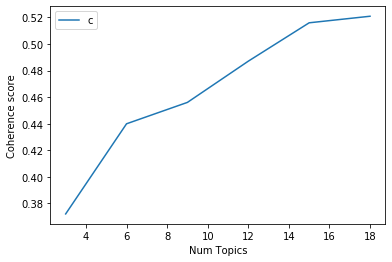

In [34]:
# Show elbow graph
import matplotlib.pyplot as plt
%matplotlib inline

limit=21; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3721
Num Topics = 6  has Coherence Value of 0.4399
Num Topics = 9  has Coherence Value of 0.456
Num Topics = 12  has Coherence Value of 0.487
Num Topics = 15  has Coherence Value of 0.5159
Num Topics = 18  has Coherence Value of 0.5208


In [36]:
# select the model based on the coherence-score elbow-plot 
optimal_model = model_list[4]
filename = 'foxcnn_model.sav'
pickle.dump(optimal_model, open(filename, 'wb'))
optimal_model = joblib.load(filename)

In [37]:
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print("Topics for the chosen LDA model:\n")
pprint(optimal_model.print_topics(num_words=10))

Topics for the chosen LDA model:

[(0,
  '0.060*"trump" + 0.042*"president" + 0.021*"state" + 0.018*"newyork" + '
  '0.016*"white_house" + 0.013*"american" + 0.012*"administration" + '
  '0.011*"cnn" + 0.011*"response" + 0.010*"cuomo"'),
 (1,
  '0.012*"country" + 0.012*"march" + 0.010*"people" + 0.009*"day" + '
  '0.008*"sunday" + 0.008*"government" + 0.008*"italy" + 0.008*"lockdown" + '
  '0.008*"report" + 0.007*"close"'),
 (2,
  '0.018*"family" + 0.017*"time" + 0.015*"home" + 0.013*"people" + '
  '0.011*"child" + 0.011*"work" + 0.011*"life" + 0.010*"make" + 0.008*"school" '
  '+ 0.007*"feel"'),
 (3,
  '0.017*"bill" + 0.015*"house" + 0.012*"american" + 0.011*"senate" + '
  '0.009*"member" + 0.009*"congress" + 0.009*"work" + 0.008*"republican" + '
  '0.008*"include" + 0.007*"democrat"'),
 (4,
  '0.054*"people" + 0.048*"case" + 0.039*"virus" + 0.033*"health" + '
  '0.029*"death" + 0.024*"number" + 0.024*"country" + 0.021*"spread" + '
  '0.015*"outbreak" + 0.014*"report"'),
 (5,
  '0.020

# Finding the dominant topic in each sentence

In [38]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [39]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = optimal_model, corpus = corpus, texts = data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)
df_dominant_topic.to_excel('LDA_foxcnn_colab.xlsx', index = False)


In [40]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [41]:
# Show
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1240,1240,8.0,0.4283,"china, chinese, world, government, country, vi...",detentions seen year old crown prince mo...
2813,2813,5.0,0.4759,"company, market, business, week, stock, millio...",almost peopl...
3806,3806,0.0,0.2109,"trump, president, state, newyork, white_house,...",kicking white house task force briefing sun...
6170,6170,13.0,0.4220,"aposs, show, write, post, daily_inbox, news_de...",grey aposs anatomy cast members took time ...
4889,4889,9.0,0.5422,"test, hospital, care, health, medical, patient...",many printing companies wanted join help ...
1522,1522,5.0,0.3538,"company, market, business, week, stock, millio...",big tech companies...
6792,6792,8.0,0.3169,"china, chinese, world, government, country, vi...",get latest news delivered daily inbox ...
3195,3195,14.0,0.4535,"team, game, player, season, event, cancel, yea...",nba suspended season last week indication ...
2719,2719,14.0,0.2749,"team, game, player, season, event, cancel, yea...",president trump comments state summer...
1803,1803,14.0,0.3253,"team, game, player, season, event, cancel, yea...",declared pandemic classification mean...


In [42]:
df_dominant_topic.to_excel('LDA_foxcnn_colab.xlsx', index = False)

# Find the most representative document for each topic

In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6127,"trump, president, state, newyork, white_house,...",trump points speaks tuesday march trum...
1,1.0,0.6204,"country, march, people, day, sunday, governmen...",buckingham palace says queen elizabeth good ...
2,2.0,0.6933,"family, time, home, people, child, work, life,...",whether housebou...
3,3.0,0.7388,"bill, house, american, senate, member, congres...",democrats republicans battle stimulus bill ...
4,4.0,0.4918,"people, case, virus, health, death, number, co...",smoking drinking general poor health resear...
5,5.0,0.7800,"company, market, business, week, stock, millio...",blog closed move come surprise nobo...
6,6.0,0.7145,"people, president, thing, trump, make, talk, e...",joe biden benefits democrat party political...
7,7.0,0.7563,"biden, state, campaign, president, election, t...",choices make individuals collectively make...
8,8.0,0.6115,"china, chinese, world, government, country, vi...",justice departmen...
9,9.0,0.5605,"test, hospital, care, health, medical, patient...",dr ashish jha dr david brett major answer ...


In [44]:
sent_topics_sorteddf_mallet.to_excel('LDA_foxcnn_colab_rep.xlsx', index = False)

In [45]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.set_index('Dominant_Topic')


In [46]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
0.0,"trump, president, state, newyork, white_house,...",617,0.0733
1.0,"country, march, people, day, sunday, governmen...",580,0.0689
2.0,"family, time, home, people, child, work, life,...",575,0.0683
3.0,"bill, house, american, senate, member, congres...",500,0.0594
4.0,"people, case, virus, health, death, number, co...",524,0.0622
5.0,"company, market, business, week, stock, millio...",536,0.0636
6.0,"people, president, thing, trump, make, talk, e...",244,0.0290
7.0,"biden, state, campaign, president, election, t...",348,0.0413
8.0,"china, chinese, world, government, country, vi...",570,0.0677
9.0,"test, hospital, care, health, medical, patient...",525,0.0623


In [47]:
df_dominant_topics.sort_values('Num_Documents', ascending = False).to_excel('LDA_foxcnn_colab_topics.xlsx', index = True)

In [48]:
pprint(df_dominant_topics.Topic_Keywords)

0.0     trump, president, state, newyork, white_house,...
1.0     country, march, people, day, sunday, governmen...
2.0     family, time, home, people, child, work, life,...
3.0     bill, house, american, senate, member, congres...
4.0     people, case, virus, health, death, number, co...
5.0     company, market, business, week, stock, millio...
6.0     people, president, thing, trump, make, talk, e...
7.0     biden, state, campaign, president, election, t...
8.0     china, chinese, world, government, country, vi...
9.0     test, hospital, care, health, medical, patient...
10.0    case, travel, test, health, confirm, quarantin...
11.0    state, order, newyork, home, city, stay, healt...
12.0    virus, drug, symptom, study, risk, dr, patient...
13.0    aposs, show, write, post, daily_inbox, news_de...
14.0    team, game, player, season, event, cancel, yea...
Name: Topic_Keywords, dtype: object


# Topic Trending Viz

In [49]:
df.head()

,index,true_time,headline,content,link,platform,true_content,clean_content
0,6889,2020-01-23 00:00:00,"Flight attendant union calls for stronger ""pre...","Dr. George Diaz, Section Chief of Infectious D...",https://www.foxnews.com/health/coronavirus-tre...,fox,"dr. george diaz, section chief of infectious d...",dr george diaz section chief infectious dis...
1,6882,2020-01-23 00:00:00,Woman reportedly bragged about using medicine ...,Fox News medical correspondent Dr. Marc Siegel...,https://www.foxnews.com/media/dr-marc-siegel-o...,fox,fox news medical correspondent dr. marc siegel...,medical correspondent dr marc siegel fears ...
2,6883,2020-01-23 00:00:00,Dr. Marc Siegel on coronavirus: 'I would reall...,Fox News Flash top headlines for Jan. 23 are h...,https://www.foxnews.com/health/coronavirus-who...,fox,"""this may expand with more cases and global tr...",may expand cases global travel chew c...
3,6884,2020-01-23 00:00:00,Coronavirus: Who is most at-risk?,"Dr. George Diaz, Section Chief of Infectious D...",https://www.foxnews.com/health/china-coronavir...,fox,"dr. george diaz, section chief of infectious d...",dr george diaz section chief infectious dis...
4,6885,2020-01-23 00:00:00,China's coronavirus outbreak kills 1st person ...,U.S. warns against travel to Chinese province ...,https://www.foxnews.com/health/coronavirus-exp...,fox,u.s. warns against travel to chinese province ...,u warns travel chinese province amid outb...


In [50]:
df_dominant_topic_date = pd.concat([df['true_time'].reset_index(), df_dominant_topic], axis = 1)
df_dominant_topic_date.head()

,index,true_time,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2020-01-23 00:00:00,0,12.0,0.4282,"virus, drug, symptom, study, risk, dr, patient...",dr george diaz section chief infectious dis...
1,1,2020-01-23 00:00:00,1,4.0,0.2795,"people, case, virus, health, death, number, co...",medical correspondent dr marc siegel fears ...
2,2,2020-01-23 00:00:00,2,12.0,0.3468,"virus, drug, symptom, study, risk, dr, patient...",may expand cases global travel chew c...
3,3,2020-01-23 00:00:00,3,1.0,0.2473,"country, march, people, day, sunday, governmen...",dr george diaz section chief infectious dis...
4,4,2020-01-23 00:00:00,4,10.0,0.2310,"case, travel, test, health, confirm, quarantin...",u warns travel chinese province amid outb...


In [51]:
df_dominant_topic_date

,index,true_time,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2020-01-23 00:00:00,0,12.0,0.4282,"virus, drug, symptom, study, risk, dr, patient...",dr george diaz section chief infectious dis...
1,1,2020-01-23 00:00:00,1,4.0,0.2795,"people, case, virus, health, death, number, co...",medical correspondent dr marc siegel fears ...
2,2,2020-01-23 00:00:00,2,12.0,0.3468,"virus, drug, symptom, study, risk, dr, patient...",may expand cases global travel chew c...
3,3,2020-01-23 00:00:00,3,1.0,0.2473,"country, march, people, day, sunday, governmen...",dr george diaz section chief infectious dis...
4,4,2020-01-23 00:00:00,4,10.0,0.2310,"case, travel, test, health, confirm, quarantin...",u warns travel chinese province amid outb...
...,...,...,...,...,...,...,...
8417,8432,2020-04-09 00:00:00,8417,13.0,0.4138,"aposs, show, write, post, daily_inbox, news_de...",president trump wednesday addressed potentia...
8418,8433,2020-04-09 00:00:00,8418,14.0,0.2049,"team, game, player, season, event, cancel, yea...",get latest news delivered daily inbox ...
8419,8434,2020-04-09 00:00:00,8419,8.0,0.3976,"china, chinese, world, government, country, vi...",get latest news delivered daily inbox ...
8420,8435,2020-04-09 00:00:00,8420,14.0,0.3192,"team, game, player, season, event, cancel, yea...",get latest news delivered daily inbox ...


In [52]:
df_dominant_topic_date.to_excel('foxcnn_dominant_topic_date.xlsx', index = False)

In [53]:
# df_dominant_topic_date.groupby(['true_time','Dominant_Topic']).agg('count')
agg_topicandtime = pd.pivot_table(df_dominant_topic_date, index=['true_time'], values = ['Document_No'], columns = ['Dominant_Topic'], aggfunc = 'count')
agg_topicandtime.to_excel('foxcnn_agg_topicandtime.xlsx')